In [1]:
# Data Manipulating and Visualization
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy.stats.mstats import winsorize
import random


# Operating System
import os
from datetime import datetime

# Machine Learning Algorithms
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

# Performance metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score

# Hyperparameter
from sklearn.model_selection import RandomizedSearchCV
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

## Mathematics and Statistics
import scipy.stats as stats
from scipy.stats import uniform
from scipy.stats import loguniform

# NLP related 
import string
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem.porter import *
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

# 1. Load modeling data
### [The creation of the the modeling data is discussed in this notebook](https://github.com/houzhj/Machine_Learning/blob/main/ipynb/imdb_data.ipynb)

In [2]:
Modeling_Date = pd.read_csv('/kaggle/input/imdb-date/Modeling_Date.csv',low_memory=False)
X_Data = Modeling_Date.drop(['movie_review','sentiment_label','sentiment_number'], axis=1)
Y_Data = Modeling_Date.sentiment_number

### First, build a model with all the 2000 features. 

In [3]:
x1,x2,y1,y2 = train_test_split(X_Data,Y_Data,test_size = 0.3,random_state = 42)

params_LGB= {'boosting_type'    : 'gbdt',
             'objective'        : 'binary',
             'colsample_bytree' : 0.8,
             'learning_rate'    : 0.05,
             'min_child_samples': 10,
             'min_child_weight' : 5,
             'max_depth'        : -1,
             'min_split_gain'   : 0,
             'num_leaves'       : 31,
             'subsample_for_bin': 50000,
             'n_estimators'     : 5000,
             'subsample_freq'   : 1
}

LGB_2000 = lgb.LGBMClassifier(**params_LGB,importance_type='gain')
LGB_2000.fit(X = x1, y = y1,
             eval_metric=['auc','logloss'], eval_set=[(x1,y1),(x2,y2)],
             callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)])

importance_df = pd.DataFrame(list(x1)).rename(columns={0:'Features'})
importance_df['importance'] = LGB_2000.feature_importances_
importance_df = importance_df.sort_values(by=['importance'],ascending=False).reset_index(drop=True)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[838]	training's auc: 0.996931	training's binary_logloss: 0.127731	valid_1's auc: 0.944385	valid_1's binary_logloss: 0.301285


### There are 1520 features with postive feature importance. 

In [4]:
importance_df[importance_df['importance']>0]

,Features,importance
0,bad,26179.362509
1,worst,20654.644251
2,wast,17914.736233
3,great,11337.439661
4,aw,9731.041632
...,...,...
1515,luck,2.224650
1516,univers,2.213020
1517,fred,2.198200
1518,dub,2.010700


### To reduce the running time, I am keeping only the top 500 features among these 2000 features in the model, based on their importance. Then conduct the feature selection analysis (below) from these 500 features. 

In [5]:
##### Keep the top 500 features
keep_features = importance_df.head(500)['Features']
X_Data_top500 = X_Data[keep_features]

# 2. Boruta
### [This article](https://towardsdatascience.com/boruta-explained-the-way-i-wish-someone-explained-it-to-me-4489d70e154a) provides a description of the general idea of Boruta
### The steps of the Boruta approach are described as the following:
- #### Step 1: Assuming we start from 2000 features. Create a shadow feature for each feature (the shadow feature for X1 is a random shuffle of the initial X1). 
- #### Step 2: Build a “Boruta” model using all the 2000 original features and the 2000 shadow features created in Step 1. Note that in this step, the Boruta model can use different algorithms. We considered light gradient boosting, extreme gradient boosting, and random forest. 
- #### Step 3: Calculate the feature importance of each feature in the “Boruta” model built in Step 2. We considered several types of feature importance. Then calculate the number of “Hit” for each original features. A feature gets a “Hit” if its importance is higher than the most importance shadow feature. 
- #### Step 4: Repeat Step 1-3 many (such as 100) times. 
- #### Step 5: Finally, select a threshold of the number of Hits “h”, and keep all the features with number of “Hits”>h. 

### Consider the Boruta approach using different combination of algorithms and type of feature imporance:


| Combo | Algorithm              | Feature Importance |
|-------|------------------------|--------------------|
| 1     | LGBMClassifier         | gain               |
| 2     | LGBMClassifier         | split              |
| 3     | XGBClassifier          | gain               |
| 4     | XGBClassifier          | weight             |
| 5     | XGBClassifier          | cover              |
| 6     | RandomForestClassifier | impurity-based     |


**Reference:
- [LGBMClassifier](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html)
- [XGBClassifier](https://xgboost.readthedocs.io/en/stable/python/python_api.html)
- [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

## 2.1 Functions
#### Boruta with LGBMClassifier

In [6]:
def Run_Boruta_LGB(params_LGB,importance_type,X_Data,Y_Data,TH_values,N_iteration):
    hits            = np.zeros(len(X_Data.columns))
    early_stopping_rounds = 50
    for iter_ in range(N_iteration):
        np.random.seed(iter_)
        X_shadow = X_Data.apply(np.random.permutation)
        X_shadow.columns = ['shadow'+ feature for feature in X_Data.columns]
        X_boruta = pd.concat([X_Data,X_shadow],axis=1,ignore_index=True)
        x_train,x_valid,y_train,y_valid = train_test_split(X_boruta,
                                                           Y_Data,
                                                           test_size = 0.3, 
                                                           random_state = 100)
        LGB_model = lgb.LGBMClassifier(**params_LGB,importance_type=importance_type)
        LGB_model.fit(X = x_train, y = y_train,
                      eval_metric=['logloss'], eval_set=[(x_train,y_train),(x_valid,y_valid)],
                      callbacks=[lgb.early_stopping(early_stopping_rounds), lgb.log_evaluation(0)])
        feature_imp_X      = LGB_model.feature_importances_[:len(X_Data.columns)]
        feature_imp_shadow = LGB_model.feature_importances_[len(X_Data.columns):]
        hits+=(feature_imp_X>feature_imp_shadow.max())
    
    Hits_df = pd.DataFrame(columns=['Feature','Hits'])
    Hits_df.iloc[:,0] = X_Data.columns
    Hits_df.iloc[:,1] = hits
    
    feature_list_dict = {}
    for i in range(len(TH_values)):
        feature_keep = Hits_df[Hits_df['Hits']>=TH_values[i]]['Feature']
        feature_list_dict['fl_boruta_'+str(TH_values[i])] = feature_keep
    return feature_list_dict

#### Boruta with XGBClassifier

In [7]:
def Run_Boruta_XGB(params_XGB,importance_type,X_Data,Y_Data,TH_values,N_iteration):
    
    hits            = np.zeros(len(X_Data.columns))
    early_stopping_rounds = 50
    for iter_ in range(N_iteration):
        print(iter_)
        np.random.seed(iter_)
        X_shadow = X_Data.apply(np.random.permutation)
        X_shadow.columns = ['shadow'+ feature for feature in X_Data.columns]
        X_boruta = pd.concat([X_Data,X_shadow],axis=1,ignore_index=True)
        x_train,x_valid,y_train,y_valid = train_test_split(X_boruta,
                                                           Y_Data,
                                                           test_size = 0.3, 
                                                           random_state = 100)
        XGB_model = xgb.XGBClassifier(**params_XGB,
                                      importance_type = importance_type,
                                      eval_metric ='logloss',
                                      early_stopping_rounds = early_stopping_rounds)
        XGB_model.fit(X = x_train, y = y_train, 
                      eval_set = [(x_train,y_train),(x_valid,y_valid)],
                      verbose  = 1000
                      )
        feature_imp_X      = XGB_model.feature_importances_[:len(X_Data.columns)]
        feature_imp_shadow = XGB_model.feature_importances_[len(X_Data.columns):]
        hits+=(feature_imp_X>feature_imp_shadow.max())
    
    Hits_df = pd.DataFrame(columns=['Feature','Hits'])
    Hits_df.iloc[:,0] = X_Data.columns
    Hits_df.iloc[:,1] = hits
    
    feature_list_dict = {}
    for i in range(len(TH_values)):
        feature_keep = Hits_df[Hits_df['Hits']>=TH_values[i]]['Feature']
        feature_list_dict['fl_boruta_'+str(TH_values[i])] = feature_keep
    return feature_list_dict

#### Boruta with RandomForestClassifier

In [8]:
def Run_Boruta_RF(params_RF,X_Data,Y_Data,TH_values,N_iteration):
    hits            = np.zeros(len(X_Data.columns))
    for iter_ in range(N_iteration):
        print(iter_)
        np.random.seed(iter_)
        X_shadow = X_Data.apply(np.random.permutation)
        X_shadow.columns = ['shadow'+ feature for feature in X_Data.columns]
        X_boruta = pd.concat([X_Data,X_shadow],axis=1,ignore_index=True)
        
        RF_model = RandomForestClassifier(**params_RF)
        RF_model.fit(X_boruta, Y_Data)
        feature_imp_X      = RF_model.feature_importances_[:len(X_Data.columns)]
        feature_imp_shadow = RF_model.feature_importances_[len(X_Data.columns):]
        hits+=(feature_imp_X>feature_imp_shadow.max())
    
    Hits_df = pd.DataFrame(columns=['Feature','Hits'])
    Hits_df.iloc[:,0] = X_Data.columns
    Hits_df.iloc[:,1] = hits
    
    feature_list_dict = {}
    for i in range(len(TH_values)):
        feature_keep = Hits_df[Hits_df['Hits']>=TH_values[i]]['Feature']
        feature_list_dict['fl_boruta_'+str(TH_values[i])] = feature_keep
    return feature_list_dict

## 2.2 Settings

In [9]:
TH_values=[1,2,3,4,5,6,7,8,9,10,20,30,40,50]
#TH_values=[1,2,3,4,5,6,7,8,9,10]
n_estimators_now = 5000

params_LGB = {'boosting_type'    : 'gbdt',
              'objective'        : 'binary',
              'colsample_bytree' : 0.2,
              'learning_rate'    : 0.05,
              'min_child_samples': 10,
              'min_child_weight' : 5,
              'max_depth'        : -1,
              'min_split_gain'   : 0,
              'num_leaves'       : 31,
              'subsample_for_bin': 50000,
              'subsample_freq'   : 1,
              'n_estimators'     : n_estimators_now
}

params_XGB = {'colsample_bylevel' : 0.2,
              'colsample_bytree'  : 0.2,
              'colsample_bynode'  : 0.2,
              'learning_rate'     : 0.05,
              'max_depth'         : 6,
              'n_estimators'      : n_estimators_now,
              'objective'         : 'binary:logistic',
              'subsample'         : 0.2,
              'scale_pos_weight'  : 1,
              'tree_method'       : 'hist'}

params_RF   = {'n_estimators'     : 1000,
               'min_samples_split': 10,
               'min_samples_leaf' : 10,
               'max_depth'        : 6,
               'max_features'     : 0.1
              }

Rerun_Boruta = 0

## Case 1: Boruta with LGBMClassifier + "gain" importance

In [10]:
if Rerun_Boruta == 1:
    LGB_gain_fl = Run_Boruta_LGB(params_LGB,'gain',X_Data_top500,Y_Data,TH_values,50)
    pd.DataFrame(LGB_gain_fl).to_csv('/kaggle/working/LGB_gain_fl.csv',index=False)
    pd.DataFrame(LGB_gain_fl)
else: 
    LGB_gain_fl = pd.read_csv('/kaggle/input/imdb-outputs/LGB_gain_fl.csv',low_memory=False)

## Case 2: Boruta with LGBMClassifier + "split" importance

In [11]:
if Rerun_Boruta == 1:
    LGB_split_fl = Run_Boruta_LGB(params_LGB,'split',X_Data_top500,Y_Data,TH_values,50)
    pd.DataFrame(LGB_split_fl).to_csv('/kaggle/working/LGB_split_fl.csv',index=False)
    pd.DataFrame(LGB_split_fl)
else: 
    LGB_split_fl = pd.read_csv('/kaggle/input/imdb-outputs/LGB_split_fl.csv',low_memory=False)

### Case 3-5 apply the XGBClassifier algorithm. This is a time-intensive method. So the dataset for XGB models are a 25% random sample from the entire population. 

In [12]:
if Rerun_Boruta == 1:
    XGB_Data = Modeling_Date.sample(frac=0.25, random_state=42)
    X_XGB_Data = XGB_Data[keep_features]
    Y_XGB_Data = XGB_Data.sentiment_number

## Case 3: Boruta with XGBClassifier + "gain" importance

In [13]:
if Rerun_Boruta == 1:
    XGB_gain_fl = Run_Boruta_XGB(params_XGB,'gain',X_XGB_Data,Y_XGB_Data,TH_values,50)
    pd.DataFrame(XGB_gain_fl).to_csv('/kaggle/working/XGB_gain_fl.csv',index=False)
    pd.DataFrame(XGB_gain_fl)
else: 
    XGB_gain_fl = pd.read_csv('/kaggle/input/imdb-outputs/XGB_gain_fl.csv',low_memory=False)

## Case 4: Boruta with XGBClassifier + "cover" importance

In [14]:
if Rerun_Boruta == 1:
    XGB_cover_fl = Run_Boruta_XGB(params_XGB,'cover',X_XGB_Data,Y_XGB_Data,TH_values,50)
    pd.DataFrame(XGB_cover_fl).to_csv('/kaggle/working/XGB_cover_fl.csv',index=False)
    pd.DataFrame(XGB_cover_fl)
else: 
    XGB_cover_fl = pd.read_csv('/kaggle/input/imdb-outputs/XGB_cover_fl.csv',low_memory=False)

## Case 5: Boruta with XGBClassifier + "weight" importance

In [15]:
if Rerun_Boruta == 1:
    XGB_weight_fl = Run_Boruta_XGB(params_XGB,'weight',X_XGB_Data,Y_XGB_Data,TH_values,50)
    pd.DataFrame(XGB_weight_fl).to_csv('/kaggle/working/XGB_weight_fl.csv',index=False)
    pd.DataFrame(XGB_weight_fl)
else: 
    XGB_weight_fl = pd.read_csv('/kaggle/input/imdb-outputs/XGB_weight_fl.csv',low_memory=False)

## Case 6: Boruta with RandomForestClassifier + impurity-based importance

### Like XGB models, random forest models are time-intensive. So the dataset for RF models are a 25% random sample from the entire population (essentially a copy of the X_XGB created above). 

In [16]:
if Rerun_Boruta == 1:
    RF_Data = Modeling_Date.sample(frac=0.25, random_state=42)
    X_RF_Data = RF_Data[keep_features]
    Y_RF_Data = RF_Data.sentiment_number

In [17]:
if Rerun_Boruta == 1:
    RF_impurity_fl = Run_Boruta_RF(params_RF,X_Data_top500,Y_Data,TH_values,50)
    pd.DataFrame(RF_impurity_fl).to_csv('/kaggle/working/RF_impurity_fl.csv',index=False)
    pd.DataFrame(RF_impurity_fl)
else: 
    RF_impurity_fl = pd.read_csv('/kaggle/input/imdb-outputs/RF_impurity_fl.csv',low_memory=False)

# 3. Compare the results from Boruta with different algorithms and type of feature importance 
## 3.1 Number of features

In [18]:
n_featuers_results = pd.DataFrame(columns=['Threshold','LGB_gain','LGB_split',
                                   'XGB_gain','XGB_cover','XGB_weight',
                                   'RF_impurity_fl'])
n_featuers_results.loc[:,'Threshold'] = [1,2,3,4,5,6,7,8,9,10,20,30,40,50]
for i in range(XGB_weight_fl.shape[1]):
    n_featuers_results.loc[i,'LGB_gain']       = len(LGB_gain_fl.iloc[:,i].dropna())
    n_featuers_results.loc[i,'LGB_split']      = len(LGB_split_fl.iloc[:,i].dropna())
    n_featuers_results.loc[i,'XGB_gain']       = len(XGB_gain_fl.iloc[:,i].dropna())
    n_featuers_results.loc[i,'XGB_cover']      = len(XGB_cover_fl.iloc[:,i].dropna())
    n_featuers_results.loc[i,'XGB_weight']     = len(XGB_weight_fl.iloc[:,i].dropna())
    n_featuers_results.loc[i,'RF_impurity_fl'] = len(RF_impurity_fl.iloc[:,i].dropna())
n_featuers_results

,Threshold,LGB_gain,LGB_split,XGB_gain,XGB_cover,XGB_weight,RF_impurity_fl
0,1,229,61,222,60,17,129
1,2,215,48,158,26,11,124
2,3,207,43,119,11,9,118
3,4,203,38,103,4,8,115
4,5,199,33,90,2,8,113
5,6,197,29,80,1,7,112
6,7,194,27,75,1,7,112
7,8,193,25,72,0,7,108
8,9,191,21,69,0,7,105
9,10,189,19,64,0,7,103


#### Going forward we only consider the feature lists with more than 20 features.

## 3.2 Comparison of Model Performance (logloss) 

In [19]:
x1,x2,y1,y2 = train_test_split(X_Data,Y_Data,test_size = 0.3,random_state = 42)

### The following function calculates the model performance(logloss) of a provided feature list, using the same training and validation datasets x1,x2,y1,y2.
### One characteristic of the LGBMClassifier() function is that the order of columns in the dataframe storing predictive features can affect the results. Even if the variables are fixed, changing their order in the data can lead to different predictions and performance metrics. However, this difference is not likely to be significant. To reduce the impact of this randomness, I randomly shuffle each feature list three times and build three models. I then calculate the average performance of these three models as the final performance for that feature list.

In [20]:
def boruta_performance(params_LGB,fl_df,x1,x2,y1,y2,combo_name):
    def get_perf(fl,x1,x2,y1,y2):
        x1_now = x1[fl]
        x2_now = x2[fl]
        LGBM = lgb.LGBMClassifier(**params_LGB)
        LGBM.fit(X = x1_now, y = y1,
                 eval_metric=['logloss'], eval_set=[(x1_now,y1),(x2_now,y2)],
                 callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)])
        metric = LGBM.best_score_['valid_1']['binary_logloss']
        return metric
    
    def fl_performance(params_LGB,fl,x1,x2,y1,y2):
        performance_df = pd.DataFrame(columns=['n_features','perf_1','perf_2','perf_3'])
        fl_shuffle_1 = fl.sample(frac=1)
        fl_shuffle_2 = fl.sample(frac=1)
        fl_shuffle_3 = fl.sample(frac=1)
        performance_df.loc[0,'n_features'] = len(fl)
        performance_df.loc[0,'perf_1']     = get_perf(fl_shuffle_1,x1,x2,y1,y2)
        performance_df.loc[0,'perf_2']     = get_perf(fl_shuffle_2,x1,x2,y1,y2)
        performance_df.loc[0,'perf_3']     = get_perf(fl_shuffle_3,x1,x2,y1,y2)
        performance_df['perf_mean'] = performance_df[['perf_1', 'perf_2', 'perf_3']].mean(axis=1)
        performance_df['perf_var']  = performance_df[['perf_1', 'perf_2', 'perf_3']].var(axis=1)
        return performance_df
    
    result = pd.DataFrame(columns=['algorithm_importance','threshold','n_feature','logloss',])
    result.loc[:,'algorithm_importance']     = [combo_name]* fl_df.shape[1]
    result.loc[:,'threshold'] = [1,2,3,4,5,6,7,8,9,10,20,30,40,50]
    for i in range(fl_df.shape[1]):
        fl = fl_df.iloc[:,i].dropna()
        result.loc[i,'n_feature'] = len(fl)
        if len(fl)>20:
            result.loc[i,'logloss'] = fl_performance(params_LGB,fl,x1,x2,y1,y2).loc[0,'perf_mean']
            
    return(result)

In [21]:
LGB_gain_result    = boruta_performance(params_LGB,LGB_gain_fl,x1,x2,y1,y2,'LGB_gain')
LGB_split_result   = boruta_performance(params_LGB,LGB_split_fl,x1,x2,y1,y2,'LGB_split')
XGB_gain_result    = boruta_performance(params_LGB,XGB_gain_fl,x1,x2,y1,y2,'XGB_gain')
XGB_cover_result   = boruta_performance(params_LGB,XGB_cover_fl,x1,x2,y1,y2,'XGB_cover')
XGB_weight_result  = boruta_performance(params_LGB,XGB_weight_fl,x1,x2,y1,y2,'XGB_weight')
RF_impurity_result = boruta_performance(params_LGB,RF_impurity_fl,x1,x2,y1,y2,'RF_impurity')

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[691]	training's binary_logloss: 0.208175	valid_1's binary_logloss: 0.319181
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[551]	training's binary_logloss: 0.225397	valid_1's binary_logloss: 0.320678
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[618]	training's binary_logloss: 0.216461	valid_1's binary_logloss: 0.320528
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[554]	training's binary_logloss: 0.227654	valid_1's binary_logloss: 0.322664
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[542]	training's binary_logloss: 0.229773	valid_1's binary_logloss: 0.32368
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[555]	training's binary_logloss: 0.22815

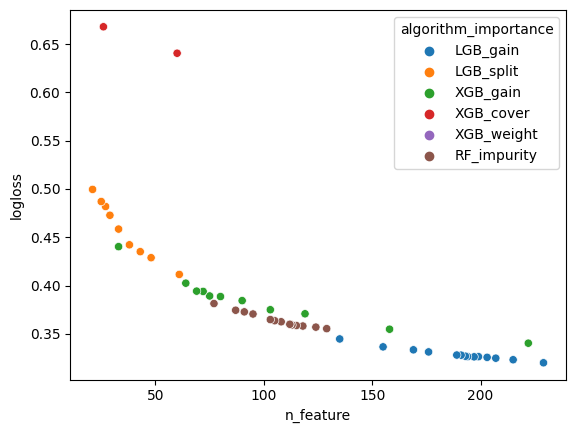

In [22]:
boruta_results = combined_df = pd.concat([LGB_gain_result,LGB_split_result,XGB_gain_result,
                                         XGB_cover_result,XGB_weight_result,RF_impurity_result], axis=0)
sns.scatterplot(data=boruta_results, x="n_feature", y="logloss", hue="algorithm_importance")
plt.show()